In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio as rio
import contextily
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import helpers

In [5]:
sns.set_style('darkgrid')

# Mali

In [2]:
lz = gpd.read_file('../../Data/IPC/LZ_adm2_geometryFix.gpkg')

In [7]:
country_names = sorted(['Chad', 'Mali', 'Niger', 'Nigeria', 'Mauritania',
                        'Burkina Faso', 'Sudan', 'South Sudan',
                        'Ethiopia', 'Uganda', 'Kenya', 'Somalia', 'Zambia',
                        'Zimbabwe', 'Mozambique', 'Malawi'])

for name in country_names:
    if name in lz.ADMIN0.unique():
        print('{}: Yes'.format(name))
    else:
        print('{}: No'.format(name))

Burkina Faso: Yes
Chad: Yes
Ethiopia: Yes
Kenya: Yes
Malawi: Yes
Mali: Yes
Mauritania: Yes
Mozambique: Yes
Niger: Yes
Nigeria: Yes
Somalia: Yes
South Sudan: Yes
Sudan: Yes
Uganda: Yes
Zambia: Yes
Zimbabwe: Yes


In [13]:
lz_test = lz[lz['ADMIN0'].isin(country_names)]

In [16]:
lz_test.head()

,FNID,EFF_YEAR,COUNTRY,ADMIN0,ADMIN1,ADMIN2,ALIASES,LZcode_fin,FIDcalc,geometry
873,ZM2012A20101,2012,ZM,Zambia,Central,Chibombo,None,2,874,"MULTIPOLYGON (((27.20152 -14.75019, 27.20152 -..."
874,ZM2012A20101,2012,ZM,Zambia,Central,Chibombo,None,2,875,"MULTIPOLYGON (((28.89224 -14.79851, 28.91501 -..."
875,ZM2012A20101,2012,ZM,Zambia,Central,Chibombo,None,3,876,"MULTIPOLYGON (((28.52088 -15.14678, 28.51710 -..."
876,ZM2012A20101,2012,ZM,Zambia,Central,Chibombo,None,3,877,"MULTIPOLYGON (((28.62619 -14.35222, 28.62680 -..."
877,ZM2012A20101,2012,ZM,Zambia,Central,Chibombo,None,4,878,"MULTIPOLYGON (((28.91501 -14.80980, 28.91601 -..."


## Livelihood zone map
These livelihood zones are outdated as far as I can tell, but they should still roughly correspond to some meaningful geographic clusters for our current purposes.

In [24]:
lz_mali = lz[lz.ADMIN0 == 'Mali']
lz_mali_proj = lz_mali.to_crs('EPSG:3857')

RuntimeError: b'no arguments in initialization list'

array([-1362841.1087316 ,   472547.66918063,  1136925.31374087,
        2875744.62435226])

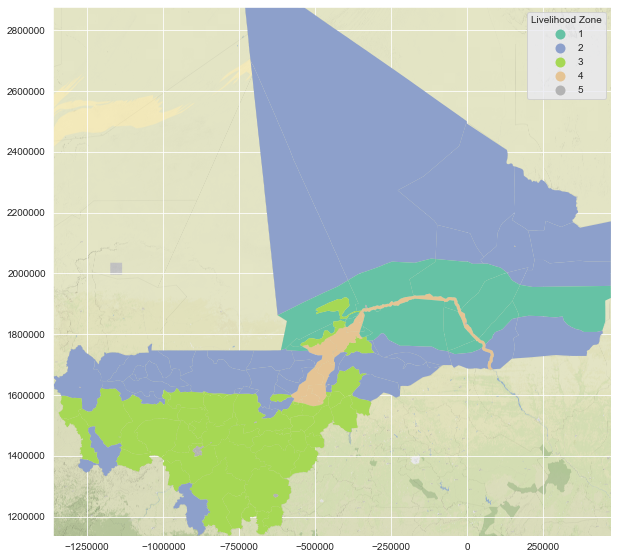

In [87]:
basemap, basemap_extent = contextily.bounds2img(*lz_mali_proj.total_bounds, zoom = 10)

plt.figure(figsize = (10,10))
plt.imshow(basemap, extent = basemap_extent, interpolation = 'bilinear')
lz_mali_proj.plot(ax = plt.gca(), column = 'LZcode_fin', cmap = 'Set2', linewidth = 0,
                  legend = True, 
                  legend_kwds = {'title': 'Livelihood Zone'})
plt.axis(lz_mali_proj.total_bounds[[0,2,1,3]])

Livelihood zone code seems to create some well-defined areas we can use to restrict our area of focus.

Now, process flood and IPC rasters for each year by aggregating into each polygon of the GeoDataFrame, so that each polygon has an IPC value and an area of flood extent value.

In [19]:
flood_dir = '../../Data/DFO flood extents/'
ipc_dir = '../../Data/IPC/updated_files/'

flood_files = [i for i in os.listdir(flood_dir) if re.match(r'msw_20\d\d\.tif$', i)]
ipc_files = [i for i in os.listdir(ipc_dir) if re.match(r'^.*201[4-9].*\.tif$', i)]

flood_years = np.arange(2014, 2020)
flood_months = np.arange(6,10)
ipc_years = [fname.split('_')[1] for fname in ipc_files]
ipc_year_month = [(int(ym[:4]), int(ym[4:])) for ym in ipc_years]

In [25]:
df_mali = helpers.add_time_to_df(lz_mali, 'FIDcalc', flood_years, np.arange(1,13))

In [26]:
df_mali

,FNID,EFF_YEAR,COUNTRY,ADMIN0,ADMIN1,ADMIN2,ALIASES,LZcode_fin,FIDcalc,geometry,Year,Month,datetime
8911,ML2001A20702,2001,ML,Mali,Gao,Ansongo,None,2,8912,"MULTIPOLYGON (((0.22935 14.98967, 0.22935 14.9...",2014,1,2014-01-01
8911,ML2001A20702,2001,ML,Mali,Gao,Ansongo,None,2,8912,"MULTIPOLYGON (((0.22935 14.98967, 0.22935 14.9...",2014,2,2014-02-01
8911,ML2001A20702,2001,ML,Mali,Gao,Ansongo,None,2,8912,"MULTIPOLYGON (((0.22935 14.98967, 0.22935 14.9...",2014,3,2014-03-01
8911,ML2001A20702,2001,ML,Mali,Gao,Ansongo,None,2,8912,"MULTIPOLYGON (((0.22935 14.98967, 0.22935 14.9...",2014,4,2014-04-01
8911,ML2001A20702,2001,ML,Mali,Gao,Ansongo,None,2,8912,"MULTIPOLYGON (((0.22935 14.98967, 0.22935 14.9...",2014,5,2014-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9116,ML2001A20205,2001,ML,Mali,Koulikoro,Kati,None,5,9117,"MULTIPOLYGON (((-7.80370 12.76437, -7.80370 12...",2019,8,2019-08-01
9116,ML2001A20205,2001,ML,Mali,Koulikoro,Kati,None,5,9117,"MULTIPOLYGON (((-7.80370 12.76437, -7.80370 12...",2019,9,2019-09-01
9116,ML2001A20205,2001,ML,Mali,Koulikoro,Kati,None,5,9117,"MULTIPOLYGON (((-7.80370 12.76437, -7.80370 12...",2019,10,2019-10-01
9116,ML2001A20205,2001,ML,Mali,Koulikoro,Kati,None,5,9117,"MULTIPOLYGON (((-7.80370 12.76437, -7.80370 12...",2019,11,2019-11-01


In [20]:
for i in range(len(ipc_files)):
    helpers.flood_ipc_rastercalc(df_mali, 
                         ipc_dir + ipc_files[i], 
                         ipc_year_month[i][0], 
                         [ipc_year_month[i][1]], 
                         ipc = 1)

for i in range(len(flood_files)):
    helpers.flood_ipc_rastercalc(df_mali,
                        flood_dir + flood_files[i],
                        flood_years[i],
                        flood_months,
                        ipc = 0)

In [21]:
df_mali.IPC_mean.fillna(method = 'backfill', inplace = True)
df_mali = df_mali.astype({'flood_prop': 'float', 'IPC_mean': 'float'})

### A basic plot to explore the relationship (if any) between flooded area as a proportion of total area on the Admin-2 level and mean IPC rating for that region.

Text(0.5, 1.0, 'Food insecurity versus flooded area for Mali by Admin 2 region, 2014–2019')

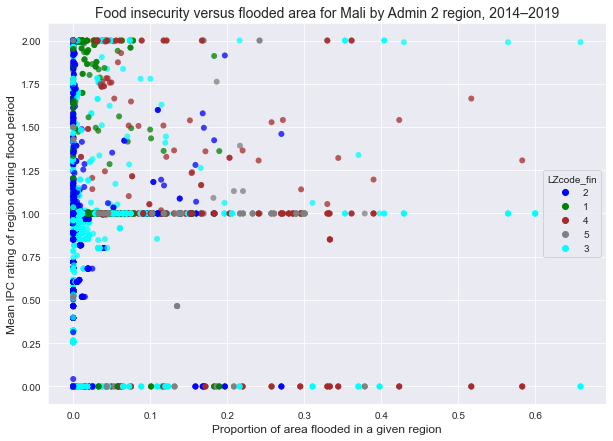

In [22]:
fig = plt.figure(figsize = (10,7))
sns.set_style('darkgrid')
sns.scatterplot(x = 'flood_prop', y = 'IPC_mean', data = df_mali, hue = 'LZcode_fin', 
                palette = ['b', 'g', 'brown', 'grey', 'cyan'],
               linewidth = 0, alpha = 0.75)
plt.xlabel('Proportion of area flooded in a given region', fontsize=12)
plt.ylabel('Mean IPC rating of region during flood period', fontsize=12)
plt.title('Food insecurity versus flooded area for Mali by Admin 2 region, 2014–2019', fontsize=14)

### Time series of flood extents and IPC ratings for each livelihood zone

In [23]:
gr_df = df_mali.groupby(['LZcode_fin', 'datetime'], as_index = False).agg({'flood_prop': 'mean', 'IPC_mean': 'mean'})

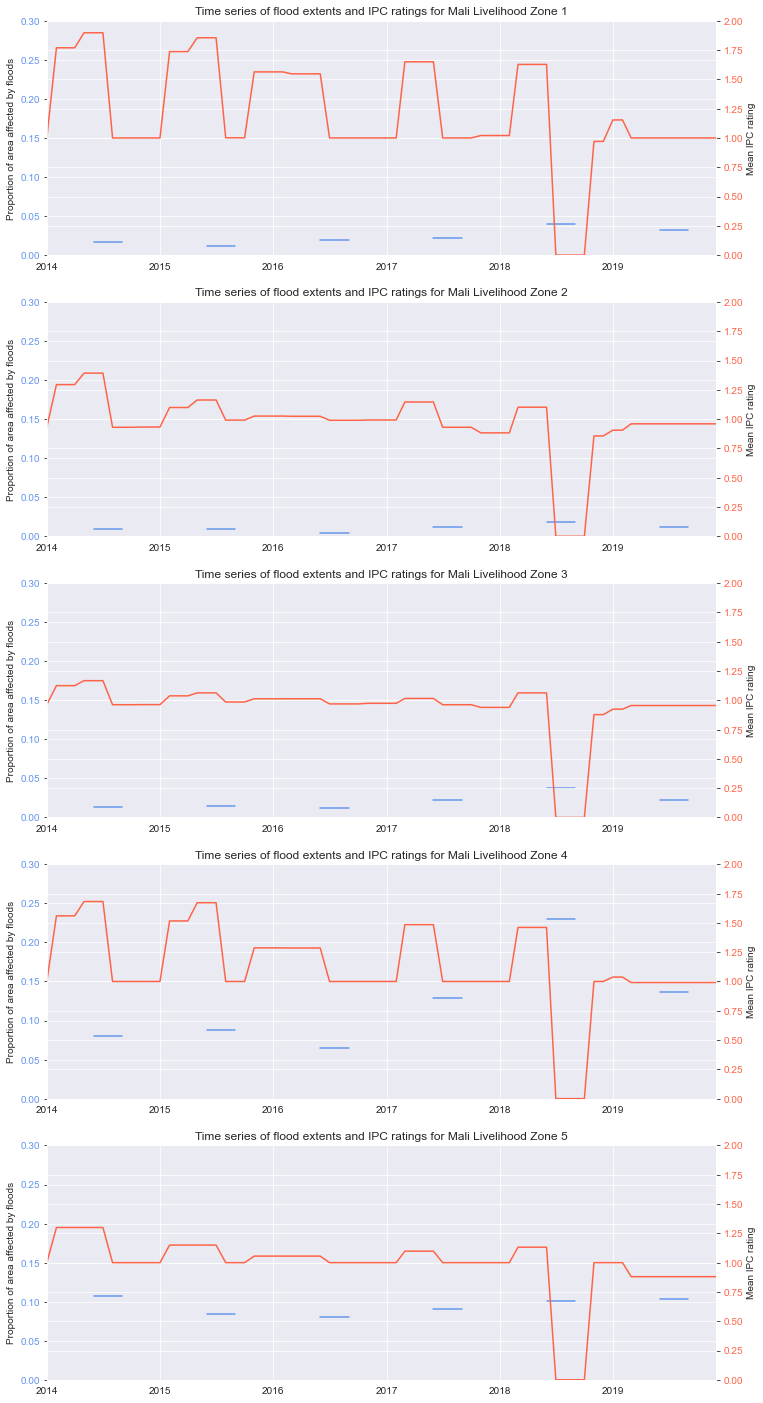

In [24]:
nrows = 5
fig, axes = plt.subplots(nrows, 1, figsize = (12, 25))

for i in range(nrows):
    x = gr_df.loc[gr_df.LZcode_fin == '{}'.format(i+1)]['datetime']
    y1 = gr_df.loc[gr_df.LZcode_fin == '{}'.format(i+1)]['flood_prop']
    y2 = gr_df.loc[gr_df.LZcode_fin == '{}'.format(i+1)]['IPC_mean']
    
    ax1 = axes[i]
    ax1.set_ylabel('Proportion of area affected by floods')
    ax1.set_xlim(gr_df.datetime.min(), gr_df.datetime.max())
    ax1.set_ylim(0, 0.3)
    ax1.plot(x, y1, color = 'cornflowerblue')
    ax1.tick_params(axis = 'y', labelcolor = 'cornflowerblue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Mean IPC rating')
    ax2.set_ylim(0, 2)
    ax2.plot(x, y2, color = 'tomato')
    ax2.tick_params(axis = 'y', labelcolor = 'tomato')
    
    plt.title('Time series of flood extents and IPC ratings for Mali Livelihood Zone {}'.format(i+1))


plt.show()
    

### Time series of flood extents and IPC gradients for each livelihood zone

In [25]:
gr_df['IPC_slope'] = np.gradient(gr_df['IPC_mean'])

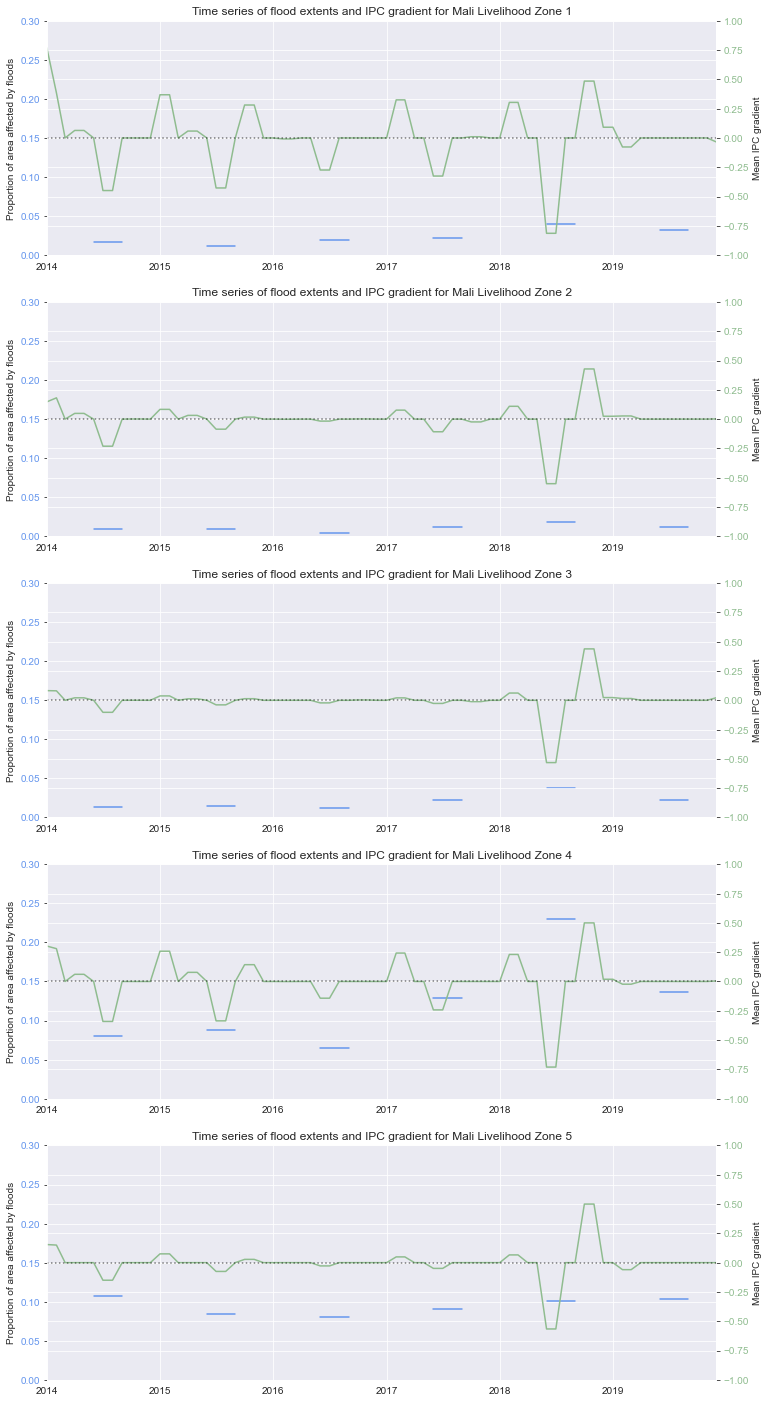

In [26]:
nrows = 5
fig, axes = plt.subplots(nrows, 1, figsize = (12, 25))

for i in range(nrows):
    x = gr_df.loc[gr_df.LZcode_fin == '{}'.format(i+1)]['datetime']
    y1 = gr_df.loc[gr_df.LZcode_fin == '{}'.format(i+1)]['flood_prop']
    y2 = gr_df.loc[gr_df.LZcode_fin == '{}'.format(i+1)]['IPC_slope']
    
    ax1 = axes[i]
    ax1.set_ylabel('Proportion of area affected by floods')
    ax1.set_xlim(gr_df.datetime.min(), gr_df.datetime.max())
    ax1.set_ylim(0, 0.3)
    ax1.plot(x, y1, color = 'cornflowerblue')
    ax1.tick_params(axis = 'y', labelcolor = 'cornflowerblue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Mean IPC gradient')
    ax2.set_ylim(-1, 1)
    ax2.plot(x, y2, color = 'darkseagreen')
    ax2.plot(x, np.zeros(72), color = 'black', linestyle = ':', alpha = 0.5)
    ax2.tick_params(axis = 'y', labelcolor = 'darkseagreen')
    
    plt.title('Time series of flood extents and IPC gradient for Mali Livelihood Zone {}'.format(i+1))


plt.show()

# Nigeria

### Livelihood zone map

In [27]:
lz_nigeria = lz[lz.ADMIN0 == 'Nigeria']
lz_nigeria_proj = lz_nigeria.to_crs('EPSG:3857')

/Users/connor/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


array([ 297048.49112795, 1634178.22710437,  475821.50442685,
       1561829.68227454])

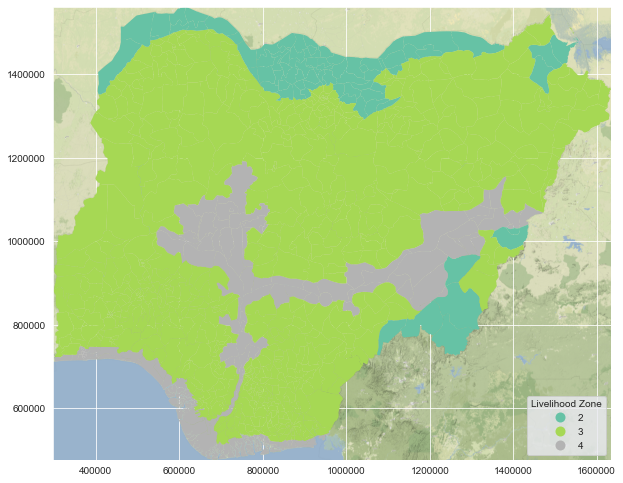

In [128]:
basemap, basemap_extent = contextily.bounds2img(*lz_nigeria_proj.total_bounds, zoom = 10)

plt.figure(figsize = (10,10))
plt.imshow(basemap, extent = basemap_extent, interpolation = 'bilinear')
lz_nigeria_proj.plot(ax = plt.gca(), column = 'LZcode_fin', cmap = "Set2", linewidth = 0,
                  legend = True, 
                  legend_kwds = {'title': 'Livelihood Zone',
                                'loc': 'lower right'})
plt.axis(lz_nigeria_proj.total_bounds[[0,2,1,3]])

### Time series of flood extents and IPC ratings for each livelihood zone

In [28]:
df_nigeria = helpers.add_time_to_df(lz_nigeria, 'FIDcalc', flood_years, np.arange(1,13))

In [29]:
for i in range(len(ipc_files)):
    helpers.flood_ipc_rastercalc(df_nigeria, 
                         ipc_dir + ipc_files[i], 
                         ipc_year_month[i][0], 
                         [ipc_year_month[i][1]], 
                         ipc = 1)

for i in range(len(flood_files)):
    helpers.flood_ipc_rastercalc(df_nigeria,
                        flood_dir + flood_files[i],
                        flood_years[i],
                        flood_months,
                        ipc = 0)

In [30]:
df_nigeria.IPC_mean.fillna(method = 'backfill', inplace = True)
df_nigeria = df_nigeria.astype({'flood_prop': 'float', 'IPC_mean': 'float'})

In [31]:
gr_df_nigeria = df_nigeria.groupby(['LZcode_fin', 'datetime'], as_index = False).agg({'flood_prop': 'mean', 'IPC_mean': 'mean'})

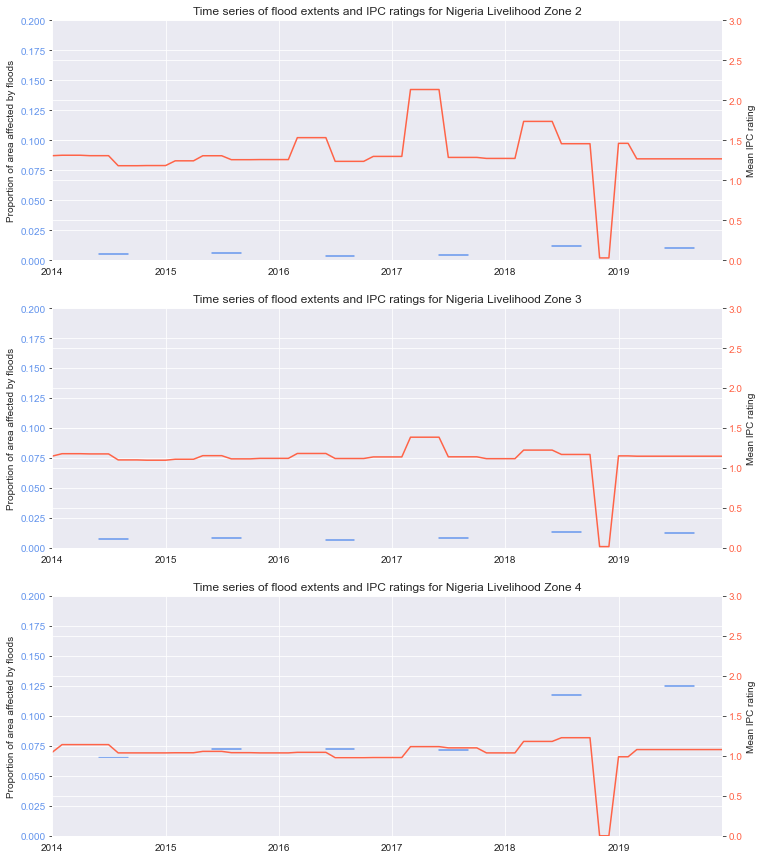

In [32]:
nrows = 3
lzs = gr_df_nigeria.LZcode_fin.unique()
fig, axes = plt.subplots(nrows, 1, figsize = (12, 15))


for i in range(nrows):
    x = gr_df_nigeria.loc[gr_df_nigeria.LZcode_fin == '{}'.format(lzs[i])]['datetime']
    y1 = gr_df_nigeria.loc[gr_df_nigeria.LZcode_fin == '{}'.format(lzs[i])]['flood_prop']
    y2 = gr_df_nigeria.loc[gr_df_nigeria.LZcode_fin == '{}'.format(lzs[i])]['IPC_mean']
    
    ax1 = axes[i]
    ax1.set_ylabel('Proportion of area affected by floods')
    ax1.set_xlim(gr_df_nigeria.datetime.min(), gr_df_nigeria.datetime.max())
    ax1.set_ylim(0, 0.2)
    ax1.plot(x, y1, color = 'cornflowerblue')
    ax1.tick_params(axis = 'y', labelcolor = 'cornflowerblue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Mean IPC rating')
    ax2.set_ylim(0, 3)
    ax2.plot(x, y2, color = 'tomato')
    ax2.tick_params(axis = 'y', labelcolor = 'tomato')
    
    
    plt.title('Time series of flood extents and IPC ratings for Nigeria Livelihood Zone {}'.format(lzs[i]))


plt.show()

### Time series of flood extents and IPC gradients for each livelihood zone

In [33]:
gr_df_nigeria['IPC_slope'] = np.gradient(gr_df_nigeria['IPC_mean'])

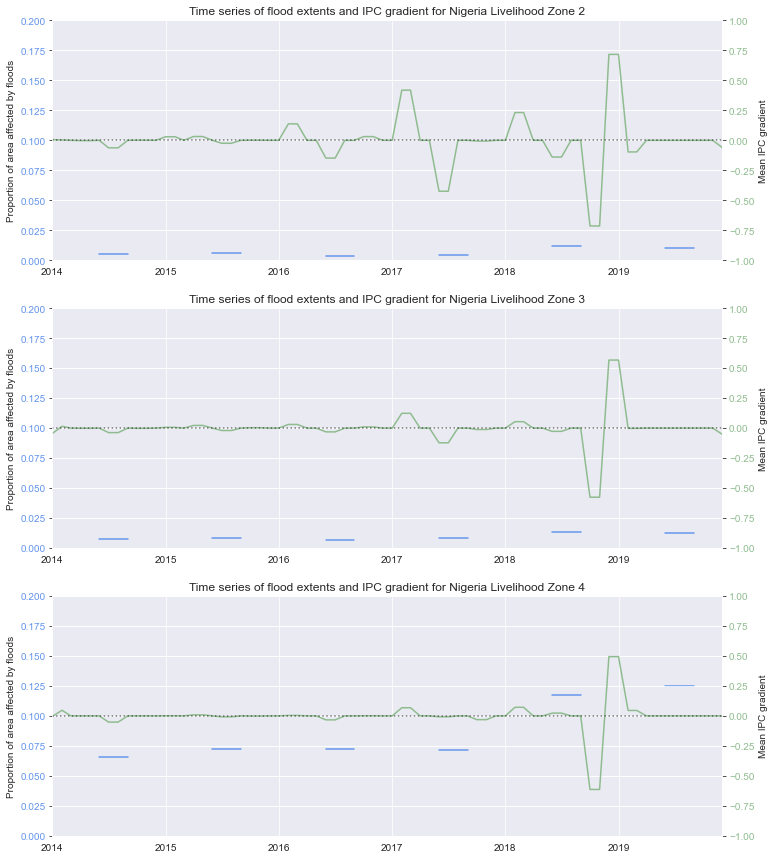

In [34]:
nrows = 3
lzs = gr_df_nigeria.LZcode_fin.unique()
fig, axes = plt.subplots(nrows, 1, figsize = (12, 15))


for i in range(nrows):
    x = gr_df_nigeria.loc[gr_df_nigeria.LZcode_fin == '{}'.format(lzs[i])]['datetime']
    y1 = gr_df_nigeria.loc[gr_df_nigeria.LZcode_fin == '{}'.format(lzs[i])]['flood_prop']
    y2 = gr_df_nigeria.loc[gr_df_nigeria.LZcode_fin == '{}'.format(lzs[i])]['IPC_slope']
    
    ax1 = axes[i]
    ax1.set_ylabel('Proportion of area affected by floods')
    ax1.set_xlim(gr_df_nigeria.datetime.min(), gr_df_nigeria.datetime.max())
    ax1.set_ylim(0, 0.2)
    ax1.plot(x, y1, color = 'cornflowerblue')
    ax1.tick_params(axis = 'y', labelcolor = 'cornflowerblue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Mean IPC gradient')
    ax2.set_ylim(-1, 1)
    ax2.plot(x, y2, color = 'darkseagreen')
    ax2.plot(x, np.zeros(72), color = 'black', linestyle = ':', alpha = 0.5)
    ax2.tick_params(axis = 'y', labelcolor = 'darkseagreen')
    
    
    plt.title('Time series of flood extents and IPC gradient for Nigeria Livelihood Zone {}'.format(lzs[i]))


plt.show()

# Niger

### Livelihood zone map

In [35]:
lz_niger = lz[lz.ADMIN0 == 'Niger']
lz_niger_proj = lz_niger.to_crs(epsg=3857)

/Users/connor/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


array([  18506.86592051, 1780626.79604918, 1311241.39466423,
       2695636.6182941 ])

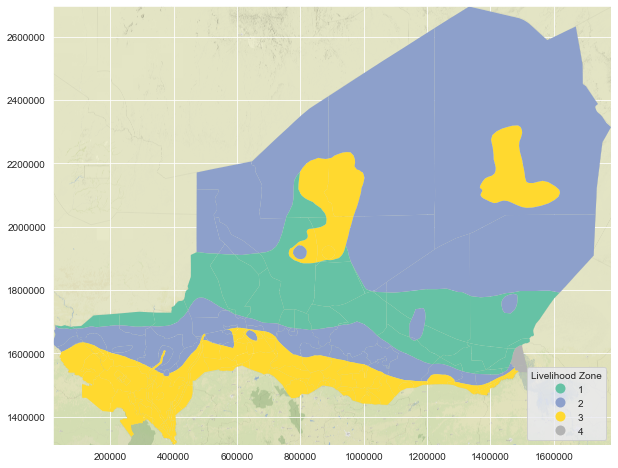

In [91]:
basemap, basemap_extent = contextily.bounds2img(*lz_niger_proj.total_bounds, zoom = 10)

plt.figure(figsize = (10,10))
plt.imshow(basemap, extent = basemap_extent, interpolation = 'bilinear')
lz_niger_proj.plot(ax = plt.gca(), column = 'LZcode_fin', cmap = 'Set2', linewidth = 0,
                  legend = True, 
                  legend_kwds = {'title': 'Livelihood Zone',
                                'loc': 'lower right'})
plt.axis(lz_niger_proj.total_bounds[[0,2,1,3]])

### Time series of flood extents and IPC ratings for each livelihood zone

In [36]:
df_niger = helpers.add_time_to_df(lz_niger, 'FIDcalc', flood_years, np.arange(1,13))

In [37]:
for i in range(len(ipc_files)):
    helpers.flood_ipc_rastercalc(df_niger, 
                         ipc_dir + ipc_files[i], 
                         ipc_year_month[i][0], 
                         [ipc_year_month[i][1]], 
                         ipc = 1)

for i in range(len(flood_files)):
    helpers.flood_ipc_rastercalc(df_niger,
                        flood_dir + flood_files[i],
                        flood_years[i],
                        flood_months,
                        ipc = 0)

In [38]:
df_niger.IPC_mean.fillna(method = 'backfill', inplace = True)
df_niger = df_niger.astype({'flood_prop': 'float', 'IPC_mean': 'float'})

In [39]:
gr_df_niger = df_niger.groupby(['LZcode_fin', 'datetime'], as_index = False).agg({'flood_prop': 'mean', 'IPC_mean': 'mean'})

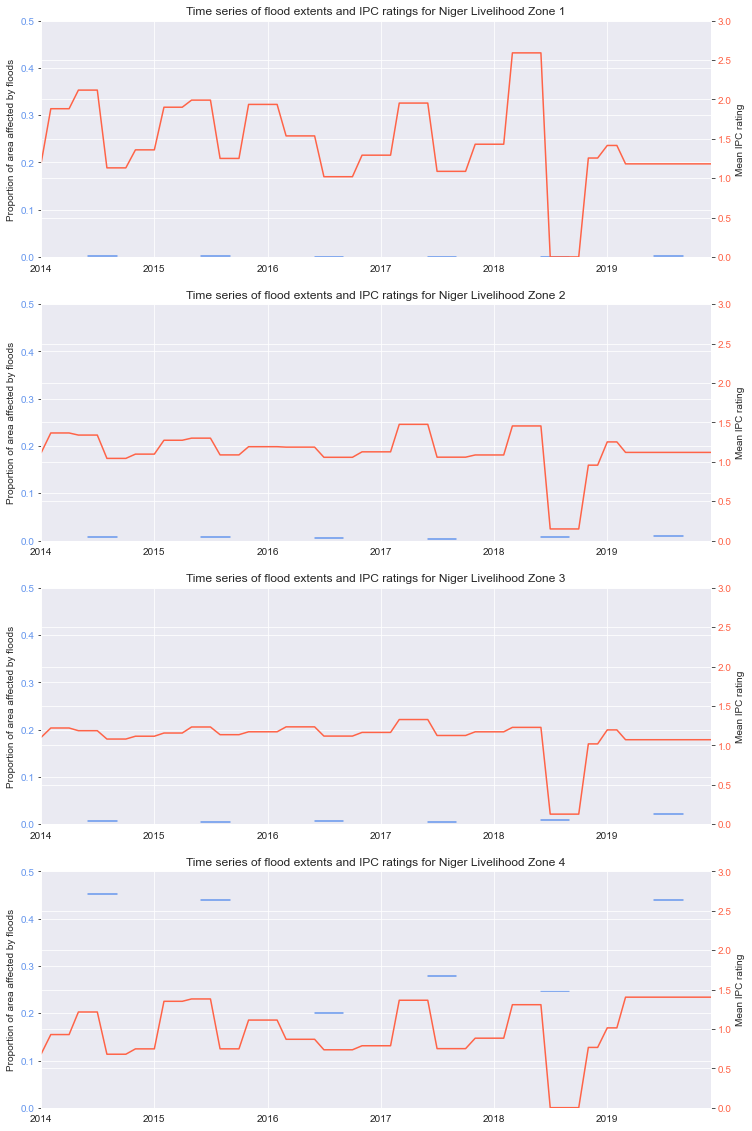

In [40]:
nrows = 4
lzs = gr_df_niger.LZcode_fin.unique()
fig, axes = plt.subplots(nrows, 1, figsize = (12, 20))


for i in range(nrows):
    x = gr_df_niger.loc[gr_df_niger.LZcode_fin == '{}'.format(lzs[i])]['datetime']
    y1 = gr_df_niger.loc[gr_df_niger.LZcode_fin == '{}'.format(lzs[i])]['flood_prop']
    y2 = gr_df_niger.loc[gr_df_niger.LZcode_fin == '{}'.format(lzs[i])]['IPC_mean']
    
    ax1 = axes[i]
    ax1.set_ylabel('Proportion of area affected by floods')
    ax1.set_xlim(gr_df_niger.datetime.min(), gr_df_niger.datetime.max())
    ax1.set_ylim(0, 0.5)
    ax1.plot(x, y1, color = 'cornflowerblue')
    ax1.tick_params(axis = 'y', labelcolor = 'cornflowerblue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Mean IPC rating')
    ax2.set_ylim(0, 3)
    ax2.plot(x, y2, color = 'tomato')
    ax2.tick_params(axis = 'y', labelcolor = 'tomato')
    
    
    plt.title('Time series of flood extents and IPC ratings for Niger Livelihood Zone {}'.format(lzs[i]))


plt.show()

From above, the data seems to be heavily distorted for LZ 4, which borders Lake Chad. The water mask used to calculate the flood extents may be more sensitive to the expansions and contractions of the Lake if there are any. Either way, the flood extent proportion is amplified both by the relative abundance of water in the area as well as the smaller region size.

### Time series of flood extents and IPC gradients for each livelihood zone

In [41]:
gr_df_niger['IPC_slope'] = np.gradient(gr_df_niger['IPC_mean'])

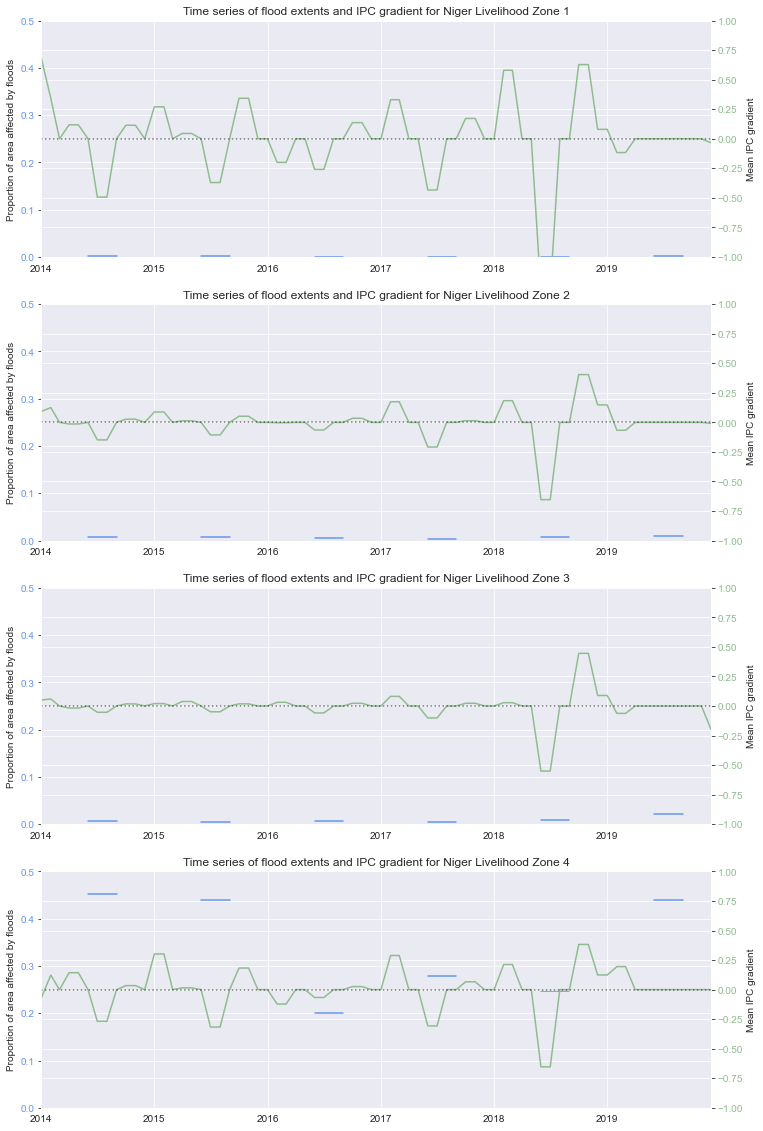

In [42]:
nrows = 4
lzs = gr_df_niger.LZcode_fin.unique()
fig, axes = plt.subplots(nrows, 1, figsize = (12, 20))


for i in range(nrows):
    x = gr_df_niger.loc[gr_df_niger.LZcode_fin == '{}'.format(lzs[i])]['datetime']
    y1 = gr_df_niger.loc[gr_df_niger.LZcode_fin == '{}'.format(lzs[i])]['flood_prop']
    y2 = gr_df_niger.loc[gr_df_niger.LZcode_fin == '{}'.format(lzs[i])]['IPC_slope']
    
    ax1 = axes[i]
    ax1.set_ylabel('Proportion of area affected by floods')
    ax1.set_xlim(gr_df_niger.datetime.min(), gr_df_niger.datetime.max())
    ax1.set_ylim(0, 0.5)
    ax1.plot(x, y1, color = 'cornflowerblue')
    ax1.tick_params(axis = 'y', labelcolor = 'cornflowerblue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Mean IPC gradient')
    ax2.set_ylim(-1, 1)
    ax2.plot(x, y2, color = 'darkseagreen')
    ax2.plot(x, np.zeros(72), color = 'black', linestyle = ':', alpha = 0.5)
    ax2.tick_params(axis = 'y', labelcolor = 'darkseagreen')
    
    
    plt.title('Time series of flood extents and IPC gradient for Niger Livelihood Zone {}'.format(lzs[i]))


plt.show()

# Chad

### Livelihood zone map

In [43]:
lz_chad = lz[lz.ADMIN0 == 'Chad']
lz_chad_proj = lz_chad.to_crs(epsg=3857)

/Users/connor/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


array([1499860.42699246, 2671963.97248568,  830674.30982165,
       2686574.7629384 ])

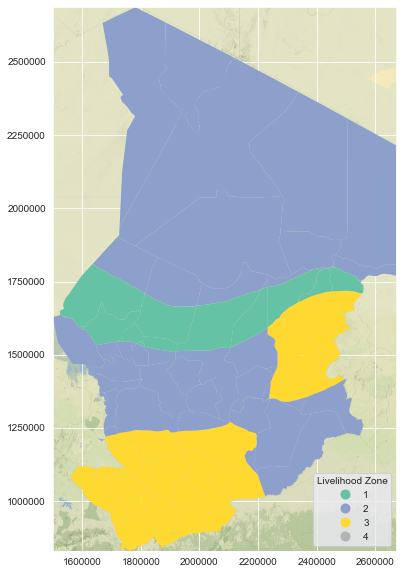

In [120]:
basemap, basemap_extent = contextily.bounds2img(*lz_chad_proj.total_bounds, zoom = 10)

plt.figure(figsize = (10,10))
plt.imshow(basemap, extent = basemap_extent, interpolation = 'bilinear')
lz_chad_proj.plot(ax = plt.gca(), column = 'LZcode_fin', cmap = 'Set2', linewidth = 0,
                  legend = True, 
                  legend_kwds = {'title': 'Livelihood Zone',
                                'loc': 'lower right'})
plt.axis(lz_chad_proj.total_bounds[[0,2,1,3]])

### Time series of flood extents and IPC ratings for each livelihood zone

In [44]:
df_chad = helpers.add_time_to_df(lz_chad, 'FIDcalc', flood_years, np.arange(1,13))

In [45]:
for i in range(len(ipc_files)):
    helpers.flood_ipc_rastercalc(df_chad, 
                         ipc_dir + ipc_files[i], 
                         ipc_year_month[i][0], 
                         [ipc_year_month[i][1]], 
                         ipc = 1)

for i in range(len(flood_files)):
    helpers.flood_ipc_rastercalc(df_chad,
                        flood_dir + flood_files[i],
                        flood_years[i],
                        flood_months,
                        ipc = 0)

In [46]:
df_chad.IPC_mean.fillna(method = 'backfill', inplace = True)
df_chad = df_chad.astype({'flood_prop': 'float', 'IPC_mean': 'float'})

In [47]:
gr_df_chad = df_chad.groupby(['LZcode_fin', 'datetime'], as_index = False).agg({'flood_prop': 'mean', 'IPC_mean': 'mean'})

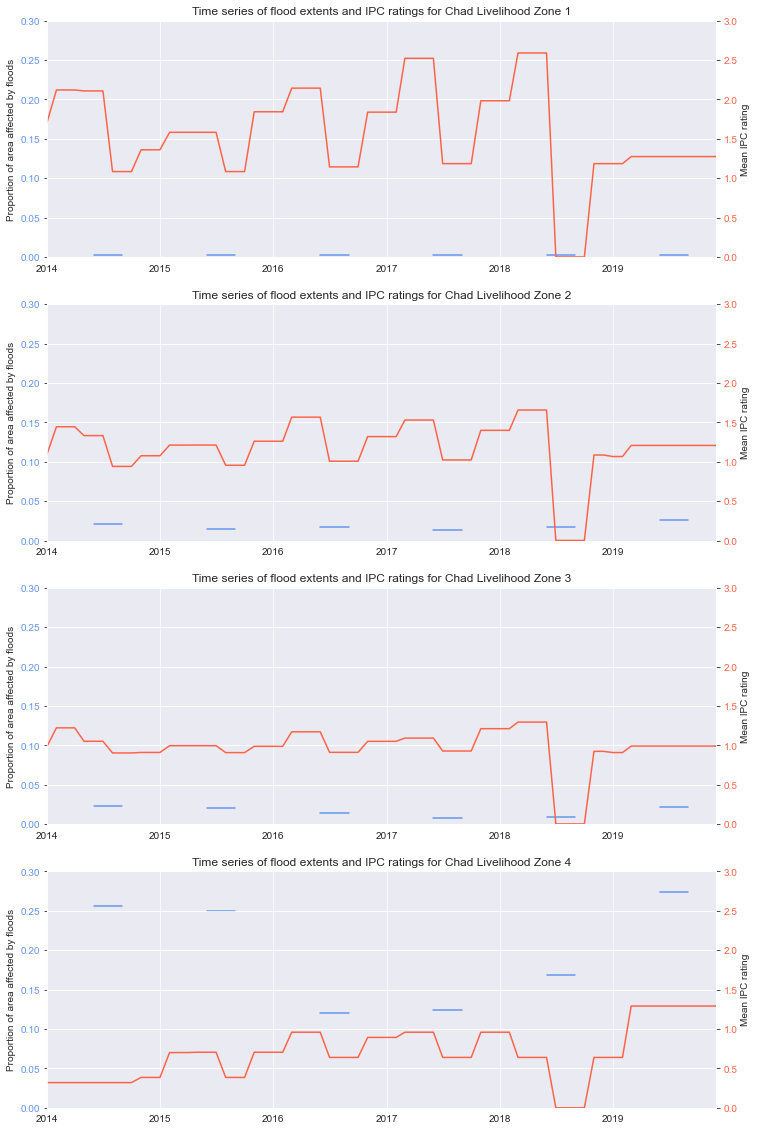

In [48]:
nrows = 4
lzs = gr_df_chad.LZcode_fin.unique()
fig, axes = plt.subplots(nrows, 1, figsize = (12, 20))


for i in range(nrows):
    x = gr_df_chad.loc[gr_df_chad.LZcode_fin == '{}'.format(lzs[i])]['datetime']
    y1 = gr_df_chad.loc[gr_df_chad.LZcode_fin == '{}'.format(lzs[i])]['flood_prop']
    y2 = gr_df_chad.loc[gr_df_chad.LZcode_fin == '{}'.format(lzs[i])]['IPC_mean']
    
    ax1 = axes[i]
    ax1.set_ylabel('Proportion of area affected by floods')
    ax1.set_xlim(gr_df_chad.datetime.min(), gr_df_chad.datetime.max())
    ax1.set_ylim(0, 0.3)
    ax1.plot(x, y1, color = 'cornflowerblue')
    ax1.tick_params(axis = 'y', labelcolor = 'cornflowerblue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Mean IPC rating')
    ax2.set_ylim(0, 3)
    ax2.plot(x, y2, color = 'tomato')
    ax2.tick_params(axis = 'y', labelcolor = 'tomato')
    
    
    plt.title('Time series of flood extents and IPC ratings for Chad Livelihood Zone {}'.format(lzs[i]))


plt.show()

### Time series of flood extents and IPC gradients for each livelihood zone

In [49]:
gr_df_chad['IPC_slope'] = np.gradient(gr_df_chad['IPC_mean'])

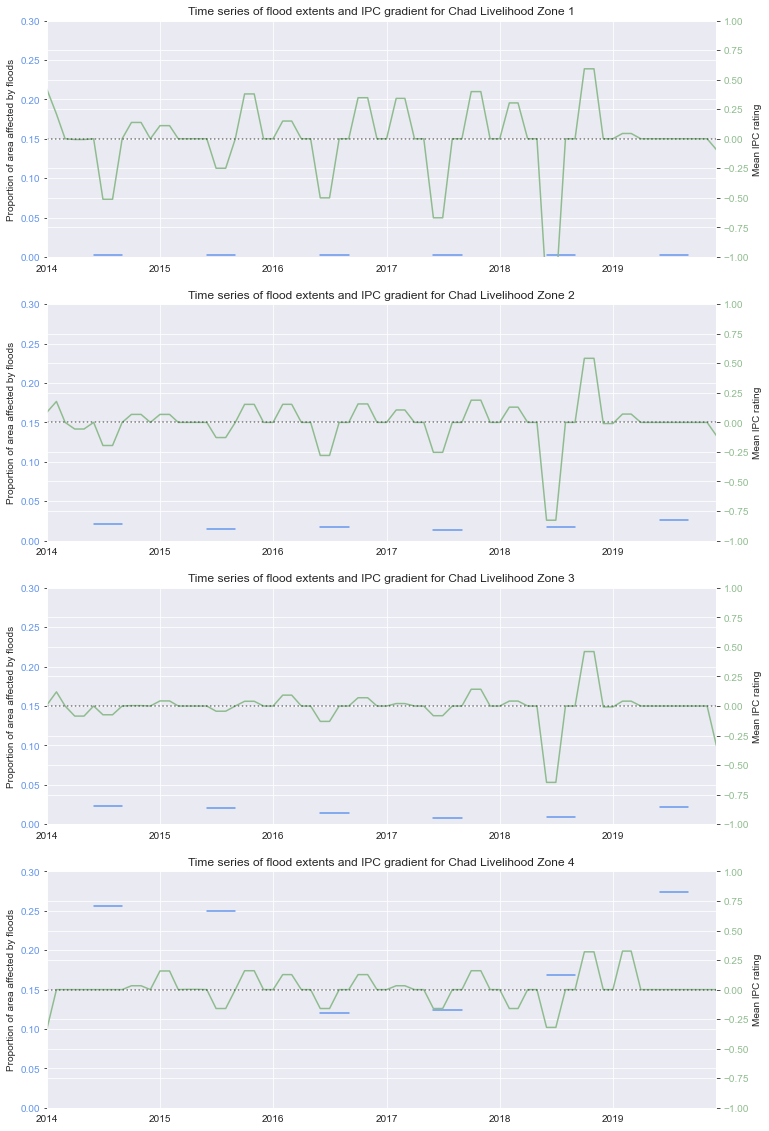

In [50]:
nrows = 4
lzs = gr_df_chad.LZcode_fin.unique()
fig, axes = plt.subplots(nrows, 1, figsize = (12, 20))


for i in range(nrows):
    x = gr_df_chad.loc[gr_df_chad.LZcode_fin == '{}'.format(lzs[i])]['datetime']
    y1 = gr_df_chad.loc[gr_df_chad.LZcode_fin == '{}'.format(lzs[i])]['flood_prop']
    y2 = gr_df_chad.loc[gr_df_chad.LZcode_fin == '{}'.format(lzs[i])]['IPC_slope']
    
    ax1 = axes[i]
    ax1.set_ylabel('Proportion of area affected by floods')
    ax1.set_xlim(gr_df_chad.datetime.min(), gr_df_chad.datetime.max())
    ax1.set_ylim(0, 0.3)
    ax1.plot(x, y1, color = 'cornflowerblue')
    ax1.tick_params(axis = 'y', labelcolor = 'cornflowerblue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Mean IPC rating')
    ax2.set_ylim(-1, 1)
    ax2.plot(x, y2, color = 'darkseagreen')
    ax2.plot(x, np.zeros(72), color = 'black', linestyle = ':', alpha = 0.5)
    ax2.tick_params(axis = 'y', labelcolor = 'darkseagreen')
    
    
    plt.title('Time series of flood extents and IPC gradient for Chad Livelihood Zone {}'.format(lzs[i]))


plt.show()